# Test biaslyze with disaster tweets data

Data source: https://www.kaggle.com/competitions/nlp-getting-started/overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [4]:
df = pd.read_csv("../data/disaster-tweets/train.csv"); df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.shape

(7613, 5)

In [6]:
# replace urls
import re
url_regex = re.compile("(http|https)://[\w\-]+(\.[\w\-]+)+\S*")

df = df.replace(to_replace=url_regex, value='', regex=True)

## Train a model

In [32]:
clf = make_pipeline(TfidfVectorizer(min_df=5, max_features=10000, stop_words="english"), LogisticRegression(n_jobs=4, C=20))

In [33]:
clf.fit(df.text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=5,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=20, n_jobs=4))])

In [34]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.target, train_pred))

0.9068698279259162


## Test detection of concepts

In [35]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
key_detect = KeywordConceptDetector()

In [37]:
detected_tweets = key_detect.detect(texts=df.text[:600])

2023-04-20 14:16:17.910 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 65527.47it/s]
2023-04-20 14:16:17.925 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 412 texts with protected concepts.


In [38]:
len(detected_tweets)

412

In [39]:
detected_tweets

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 '#Flood in Bago Myanmar #We arrived Bago',
 "What's up man?",
 'this is ridiculous....',
 'Love my girlfriend',
 'The end!',
 'We always try to bring the he

## Test LIME based bias detection with keywords

In [40]:
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [41]:
bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=500), n_top_keywords=30, use_tokenizer=True)

In [42]:
detection_res = bias_detector.detect(texts=df.text.sample(frac=0.3), predict_func=clf.predict_proba)

2023-04-20 14:16:27.072 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 2284 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2284/2284 [00:24<00:00, 93.13it/s]
2023-04-20 14:16:51.600 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 383 texts with protected concepts.
2023-04-20 14:16:51.601 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 383 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [01:32<00:00,  4.13it/s]


In [43]:
detection_res.summary()

Detected 367 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 231), ('nationality', 126), ('religion', 20)]
    Based on keywords: [('he', 47), ('his', 38), ('california', 36), ('man', 34), ('her', 26), ('she', 23), ('japan', 16), ('woman', 13), ('boy', 12), ('mom', 11), ('women', 11), ('christian', 9), ('islam', 8), ('china', 8), ('men', 8), ('israeli', 7), ('pakistan', 7), ('russian', 7), ('girl', 7), ('muslims', 6)].


In [44]:
detection_res.details(group_by_concept=True)

Concept: nationality
[{'reason': ['california'],
  'text': ' The Latest: More homes razed by Northern California wildfire - '
          'Lynchburg News and Advance '},
 {'reason': ['saudi'],
  'text': 'Suicide bomber kills 15 in Saudi security site mosque - Reuters '
          'Canada: Reuters CanadaSuicide bomber kills 15 ... '},
 {'reason': ['egypt'],
  'text': 'Islamic State group in Egypt threatens to kill Croat hostage '},
 {'reason': ['israeli', 'muslims', 'christian'],
  'text': 'Christian Attacked by Muslims at the Temple Mount after Waving '
          'Israeli Flag via Pamela Geller - ... '},
 {'reason': ['finnish'],
  'text': 'Finnish ministers: Fennovoima nuclear reactor will go ahead via '
          '/r/worldnews '},
 {'reason': ['japan'],
  'text': '#Setting4Success Bells toll in Hiroshima as Japan marks 70 years '
          'since atomic bombing #News #smallbusiness #entrepreneur'},
 {'reason': ['japan'],
  'text': '#Japan marks 70th anniversary of #Hiroshima atomic bombi

In [46]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

Loading BokehJS ...

In [48]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [67]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

In [70]:
detection_res.biased_samples[0].score

0.20665614817061592

In [128]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs, embeddings)

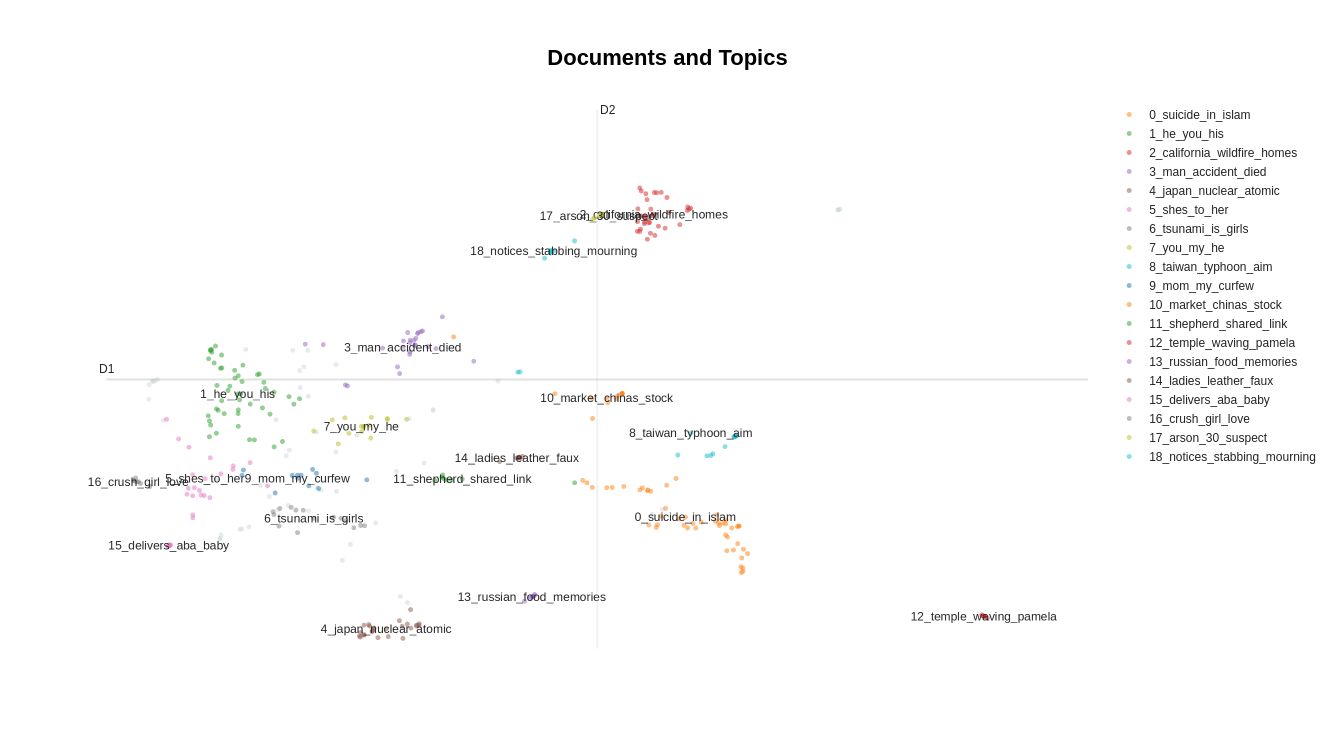

In [129]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [247]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput
from bokeh.palettes import Spectral5, Accent5, Category10_5
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_5[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

In [175]:
concept2intd

['religion,gender',
 'nationality',
 'gender',
 'religion',
 'nationality,religion']

## Testing a sentiment analysis model from huggingface

In [25]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [26]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [27]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [28]:
test_texts = detected_tweets[:10]
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

2023-04-13 10:09:41.105 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 10 texts...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 109.41it/s]
2023-04-13 10:09:41.200 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 2 texts with protected concepts.
2023-04-13 10:09:41.201 | INFO     | biaslyze.evaluators:evaluate:42 - Started bias detection on 2 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:38<00:00, 19.30s/it]


In [29]:
detection_res.summary()

Detected 1 samples with potential issues.
    Potentially problematic concepts detected: [('nationality', 1)]
    Based on keywords: [('california', 1)].


In [30]:
detection_res.details(group_by_concept=True)

Concept: nationality
[{'reason': ['california'],
  'text': '13,000 people receive #wildfires evacuation orders in California '}]


## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [31]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector

In [466]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=20, use_tokenizer=True)

In [467]:
masked_detection_res = bias_detector.detect(texts=df.sample(1000).text, predict_func=clf.predict_proba)

2023-04-14 11:59:35.431 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.34it/s]
2023-04-14 11:59:45.817 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 170 texts with protected concepts.
2023-04-14 11:59:45.817 | INFO     | biaslyze.evaluators:evaluate:109 - Started bias detection on 170 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:10<00:00, 17.00it/s]


In [468]:
masked_detection_res.summary()

Detected 91 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 49), ('nationality', 42), ('religion', 1)]
    Based on keywords: [('he', 12), ('man', 10), ('california', 10), ('his', 8), ('japan', 7), ('she', 6), ('her', 5), ('boy', 4), ('women', 3), ('turkish', 3), ('china', 3), ('woman', 3), ('german', 3), ('guy', 2), ('ladies', 2), ('daughter', 2), ('myanmar', 2), ('men', 2), ('russia', 2), ('palestine', 2)].


In [469]:
masked_detection_res.details()

''Another white guy trying to mass murder people for no apparent reason just because let me guess he's mentally ill blah blah blah #Antioch'' might contain bias ['gender']; reasons: ['he', 'guy']
''2015 new fashion ladies gold watch waterproof WeiQin famous brand michel quartz de lujo caÛ_  '' might contain bias ['gender']; reasons: ['ladies']
''@O_Magazine satan's daughter shadow warrior in 50ft women aka transgender mode ps nyc is about to fold extra extra center of bioterrorism'' might contain bias ['gender']; reasons: ['women', 'daughter']
''Turkish troops killed in Kurdish militant 'suicide attack' '' might contain bias ['nationality']; reasons: ['turkish']
''Chinese rescue team arrives in Myanmar to help flood victims  Sittway '' might contain bias ['nationality']; reasons: ['myanmar', 'chinese']
''@APANO55 @JamesMelville 99% of Scientists donÛªt believe in Catastrophic Man-Made Global Warming only the deluded do.'' might contain bias ['gender']; reasons: ['man', 'man']
''ÛÏ@B

In [471]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = masked_detection_res.dashboard()
show(dashboard)

Loading BokehJS ...